In [3]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload
from astropy.io import fits

from matplotlib.colors import LogNorm, Normalize, CenteredNorm
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

from scoobscc.math_module import xp, xcipy, ensure_np_array
from scoobscc import utils
from scoobscc import dm
from scoobscc import scc_sim as scc
import scoobscc.scoob_model as scoobm

wfe_data = utils.load_pickle('/home/derbyk/src/scoob-scc/data_sim/example_wfe_data.pkl')

Oversampling > 2x suggested for reliable results in Fresnel propagation.


Could not import ray. Parallelized model unavailble.


Text(0.5, 1.0, 'Modulated Coro Image')

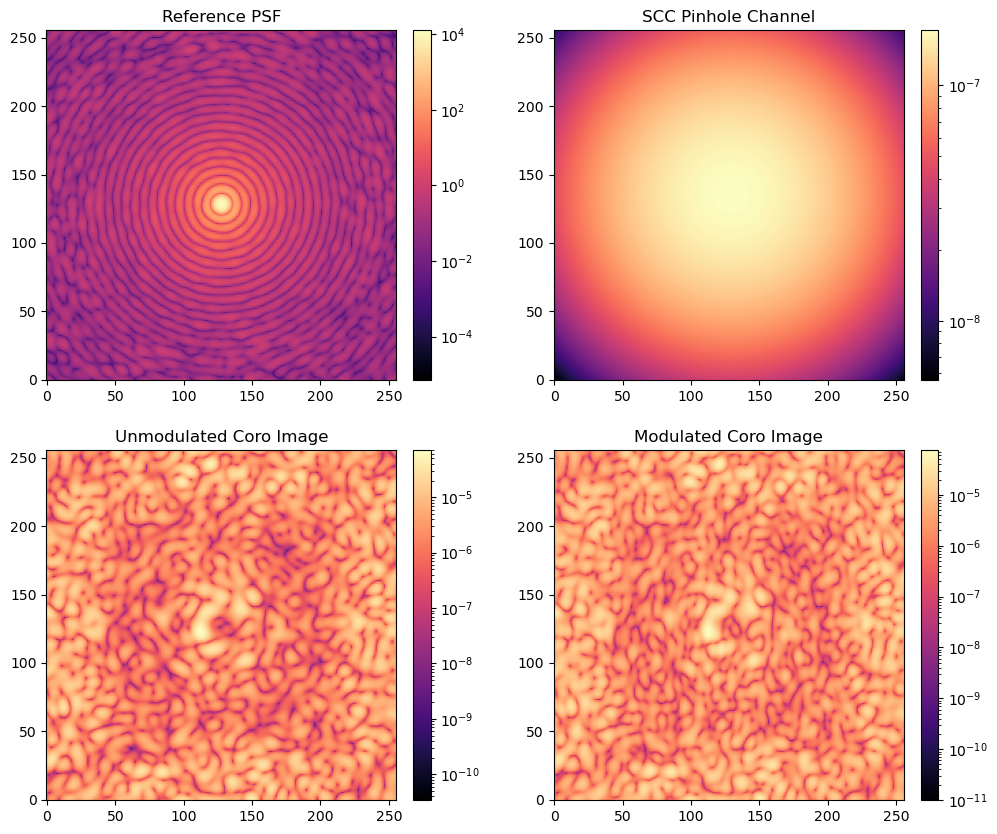

In [4]:
reload(scoobm)
reload(utils)

M = scoobm.single()
M.ncamsci = 256

M.PREFPM_AMP = wfe_data['PREFPM_AMP']
M.PREFPM_OPD = wfe_data['PREFPM_OPD']

M.POSTFPM_AMP = wfe_data['POSTFPM_AMP']
M.POSTFPM_OPD = wfe_data['POSTFPM_OPD']

M.RLS_AMP = wfe_data['RLS_AMP']
M.RLS_OPD = wfe_data['RLS_OPD']

M.dm_ref = wfe_data['DM_FLAT']
M.reset_dm()

iwa = 3
owa = 10
# control_mask = utils.create_annular_focal_plane_mask(
control_mask = utils.create_annular_mask(
    M.ncamsci, 
    M.camsci_pxscl_lamD, 
    iwa, 
    owa,  
    edge=iwa,
    rotation=90,
)
# imshow1(control_mask, pxscl=M.camsci_pxscl_lamD)

M.LYOT = M.LYOTSTOP
M.use_vortex = 0
ref_psf = M.snap_camsci()
M.Imax_ref = xp.max(ref_psf)

M.use_vortex = 1
im_unmod = M.snap_camsci()
mean_contrast_unmod = xp.mean(im_unmod[control_mask])

M.LYOT = M.PINHOLE
ref_scc = M.snap_camsci()

M.LYOT = M.SCCSTOP
im_mod = M.snap_camsci()
mean_contrast_mod = xp.mean(im_mod[control_mask])

plt.figure(figsize=(12, 10))
plt.subplot(221)
plt.imshow(ref_psf.get(), cmap='magma', norm='log',)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Reference PSF')
plt.subplot(222)
plt.imshow(ref_scc.get(), cmap='magma', norm='log',)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('SCC Pinhole Channel')
plt.subplot(223)
plt.imshow(im_unmod.get(), cmap='magma', norm='log',)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Unmodulated Coro Image')
plt.subplot(224)
plt.imshow(im_mod.get(), cmap='magma', norm='log',)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Modulated Coro Image')

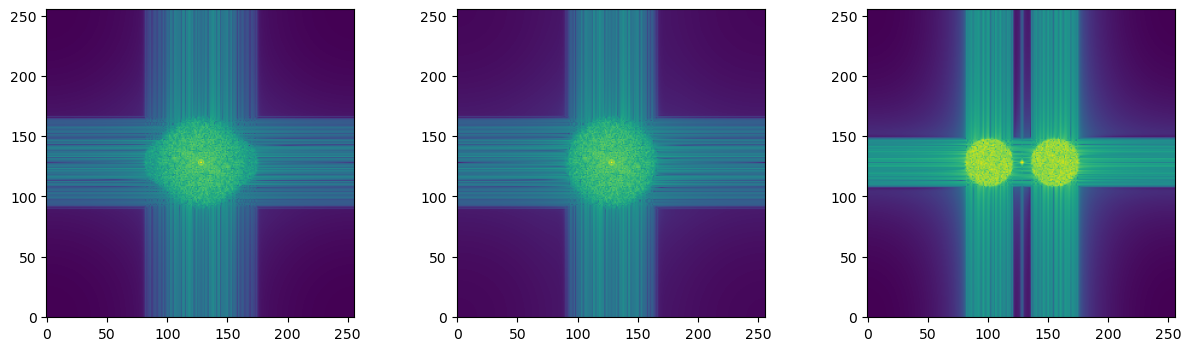

In [5]:
mod_fft = im_fft = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(im_mod), norm='ortho'))
unmod_fft = im_fft = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(im_unmod), norm='ortho'))
diff = mod_fft - unmod_fft

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(xp.abs(mod_fft).get(), norm='log')
plt.subplot(132)
plt.imshow(xp.abs(unmod_fft).get(), norm='log')
plt.subplot(133)
plt.imshow(xp.abs(diff).get(), norm='log')

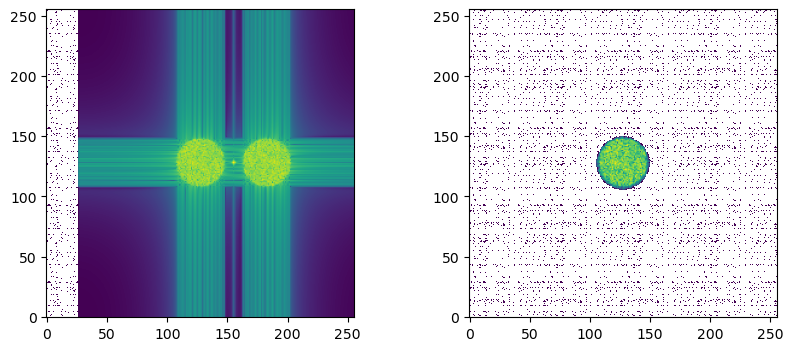

In [6]:
diff_shifted = xcipy.ndimage.shift(diff, (0, 27))

x, y = xp.meshgrid(xp.linspace(-1, 1, diff_shifted.shape[0]), xp.linspace(-1, 1, diff_shifted.shape[0]))
r = xp.sqrt(x ** 2 + y ** 2)
mask = r < 0.17

diff_masked = diff_shifted * mask

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(xp.abs(diff_shifted).get(), norm='log')
plt.subplot(122)
plt.imshow(xp.abs(diff_masked).get(), norm='log')

Text(0.5, 1.0, 'Difference')

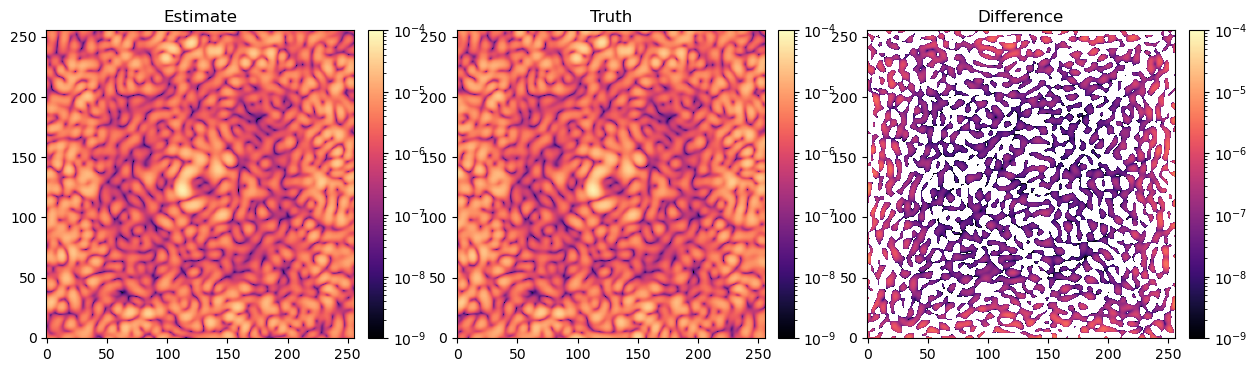

In [7]:
estimate = xp.fft.ifftshift(xp.fft.fft2(xp.fft.fftshift(diff_masked), norm='ortho'))
estimate /= np.sqrt(ref_scc)

plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(xp.abs(estimate).get() ** 2, cmap='magma', norm='log', vmin=1e-9, vmax=1e-4)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Estimate')
plt.subplot(132)
plt.imshow(im_unmod.get(), cmap='magma', norm='log', vmin=1e-9, vmax=1e-4)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Truth')
plt.subplot(133)
plt.imshow(xp.abs(estimate).get() ** 2 - im_unmod.get(), cmap='magma', norm='log', vmin=1e-9, vmax=1e-4)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Difference')